## Q1
### 1.1

Given
$$
x\mid \theta \;\sim\; \mathcal{N}\bigl(C\,\theta,\;Q\bigr),
\quad
y\mid x \;\sim\; \mathcal{N}\bigl(A\,x,\;R\bigr),
$$

We first compute the likelihood of y, given by
$$
p(y\mid \theta)
\;=\;\int p(y\mid x)\,p(x\mid \theta)\,dx.
$$

$$
= \int \mathcal{N}\bigl(y; A\,x,\;R\bigr) \mathcal{N}\bigl(x; C\,\theta,\;Q\bigr) dx
$$

$$
= \mathcal{N}\!\Bigl(
y;\;A\,C\,\theta,\;A\,Q\,A^\top + R
\Bigr)
$$

Now we construct the posterior 
$$
p(\theta\mid y)
\propto
p(\theta) \; p(y\mid \theta)
$$

$$
\propto
\mathcal{N}\bigl(\theta; m \; P )
\;
\mathcal{N}\!\Bigl(
y;\;A\,C\,\theta,\;A\,Q\,A^\top + R
\Bigr)
$$

Write 
$$
p(\theta\mid y) = \mathcal{N}(y; \Mu, \Sigma)
$$
then using Lemma 3.1, the posterior covariance is given by
$$
\Sigma \;=\;
P - P (AC)^\top \Bigl( A\,Q\,A^\top + R + (AC) P (AC) ^\top \Bigr)^{-1} (AC) P
$$

Or equivalently in a more elegant form
$$
\Sigma \;=\;
\bigl[P^{-1} + C^\top A^\top (A\,Q\,A^\top + R)^{-1} A\,C\bigr]^{-1}.
$$ 





By Lemma 3.1, the posterior mean $\Mu$ is given by
$$
\Mu = m + P (AC)^\top \Bigl( A\,Q\,A^\top + R + (AC) P (AC) ^\top \Bigr)^{-1} (y - ACm)
$$

or more elegantly
$$
\Mu = \Sigma\bigl[P^{-1}m + C^\top A^\top (A\,Q\,A^\top + R)^{-1}y\bigr]
$$


### 1.2
We plug in those:
$$
m = \begin{pmatrix}2 \\[4pt] 0\end{pmatrix},\quad 
P = I_2,\quad
C = \begin{pmatrix}1 & 1\\[4pt] 1 & 1.01\end{pmatrix},\quad 
Q = 0.01\,I_2.
$$

$$
A = \begin{pmatrix}1 & 0 \\[4pt]\varepsilon & 0\end{pmatrix},\quad 
R = \varepsilon\,I_2,\quad
y = \begin{pmatrix}1\\[3pt]1\end{pmatrix}.
$$

Note when computing the posterior mean and var, I have checked that both expressions yield identical numerical values, so I will use only the more elegant format here


In [1]:
import numpy as np
import pandas as pd

m = np.array([[2], [0]])
P = np.eye(2)
C = np.array([[1, 1], [1, 1.01]])
Q = 0.01 * np.eye(2)
y = np.array([[1], [1]])
A_base = np.array([[1, 0], [0, 0]], dtype=float)  # Base part of A
R_base = np.array([[1, 0], [0, 1]], dtype=float)  # Base part of R

epsilons = np.logspace(-3, 0, num=4)  # 10^-3, 10^-2, 10^-1, 10^0
post_var = []
post_means = []

for epsilon in epsilons:
    A = A_base.copy()
    A[1, 0] = epsilon  # Update A with the varying epsilon
    R = epsilon * R_base  # Update R with the varying epsilon

    S = A @ Q @ A.T + R

    Sigma = np.linalg.inv(P + C.T @ A.T @ np.linalg.inv(S) @ A @ C)

    # Store the trace of Sigma (a measure of total variance)
    post_var.append(np.round(Sigma, 4))

    post_mean = Sigma @ (np.linalg.inv(P) @ m + C.T @ A.T @ np.linalg.inv(S) @ y)
    post_means.append(np.round(post_mean.flatten(), 4)) # store 4 digits

    # post_mean2 = m + P @ (A @ C).T @ np.linalg.inv(S + (A @ C) @ P @ (A @ C).T) @ (y - A @ C @ m)

# Create a DataFrame for visualization
df_post = pd.DataFrame(
    {"Epsilon": epsilons, 
    "Posterior Mean": post_means,
     "Posterior Variance": post_var}
    )
df_post

,Epsilon,Posterior Mean,Posterior Variance
0,0.001,"[1.5032, -0.4968]","[[0.5027, -0.4973], [-0.4973, 0.5027]]"
1,0.010,"[1.5099, -0.4901]","[[0.505, -0.495], [-0.495, 0.505]]"
2,0.100,"[1.5681, -0.4319]","[[0.5258, -0.4742], [-0.4742, 0.5258]]"
3,1.000,"[1.6016, -0.3984]","[[0.6016, -0.3984], [-0.3984, 0.6016]]"


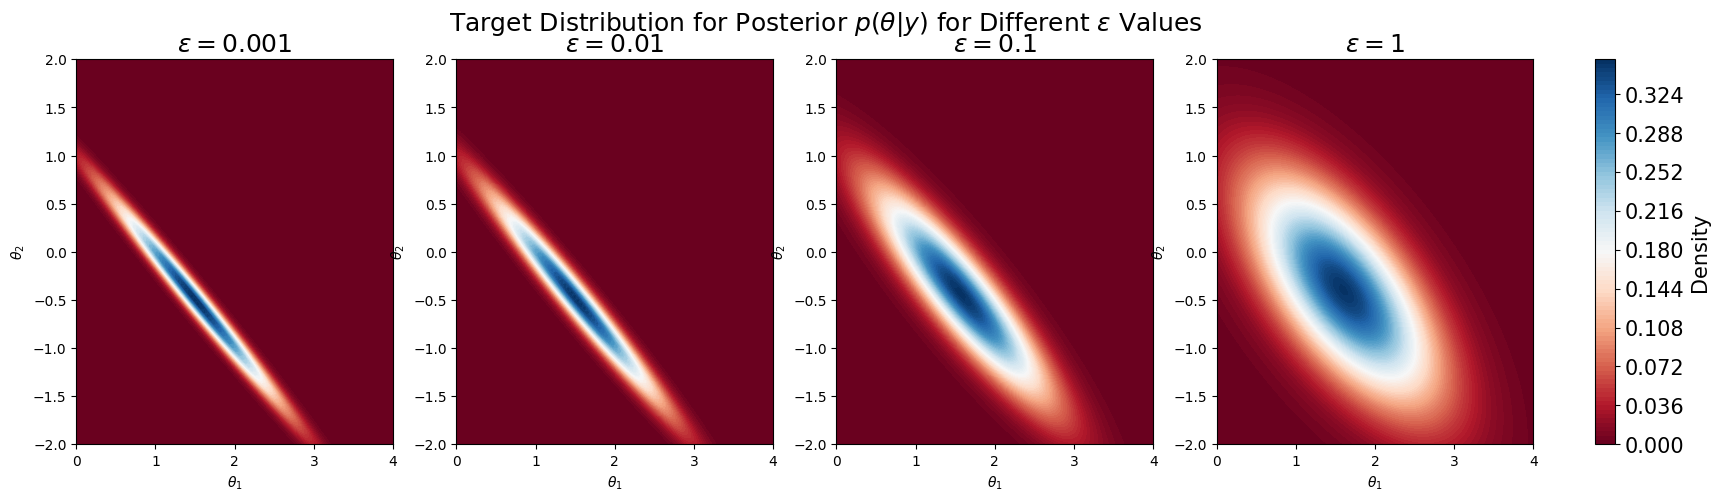

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Define grid for contour plot
x_bb = np.linspace(0, 4, 100)
y_bb = np.linspace(-2, 2, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plt.rcParams.update({'font.size': 15})  # Set font size

for i in df_post.index:
    eps = df_post['Epsilon'][i]
    post_mean = df_post['Posterior Mean'][i]
    post_var = df_post['Posterior Variance'][i]

    # rv = multivariate_normal(mean=mu_theta, cov=Sigma)
    rv = multivariate_normal(mean=post_mean, cov=post_var)

    # Evaluate the posterior density on the grid
    pos = np.dstack((X_bb, Y_bb))
    Z_bb = rv.pdf(pos)

    # Plot the contour
    ax = axes[i]
    cnt = ax.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
    ax.set_title(f'$\\epsilon = {eps:.3g}$')
    ax.set_xlabel('$\\theta_1$')
    ax.set_ylabel('$\\theta_2$')

# Add colorbar
fig.colorbar(cnt, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, label='Density')
plt.suptitle('Target Distribution for Posterior $p(\\theta | y)$ for Different $\\epsilon$ Values')
plt.show()


### 1.3

My RWMH algorithm follows these steps:

1. **Initialize** at $x_0 = (0, 0)$
2. For each iteration:
   - **Propose** a new state:  
     $$ x_s = x_{n-1} + \sigma_{\text{rw}} \cdot \mathcal{N}(0, I) $$
   - **Compute acceptance probability**:  
     $$ a = \min\left(1, \frac{\pi(x_s)}{\pi(x_{n-1})} \right) $$
   - **Accept or reject**:
     - With probability $a$, set $x_n = x_s $.
     - Otherwise, set $ x_n = x_{n-1} $.

I set $\sigma_{\text{rw}} = 0.5 $.
If it's too small, proposals are close to the current state → slow exploration.  
Otherwise if too large, proposals often land in low-probability regions → high rejection rate.


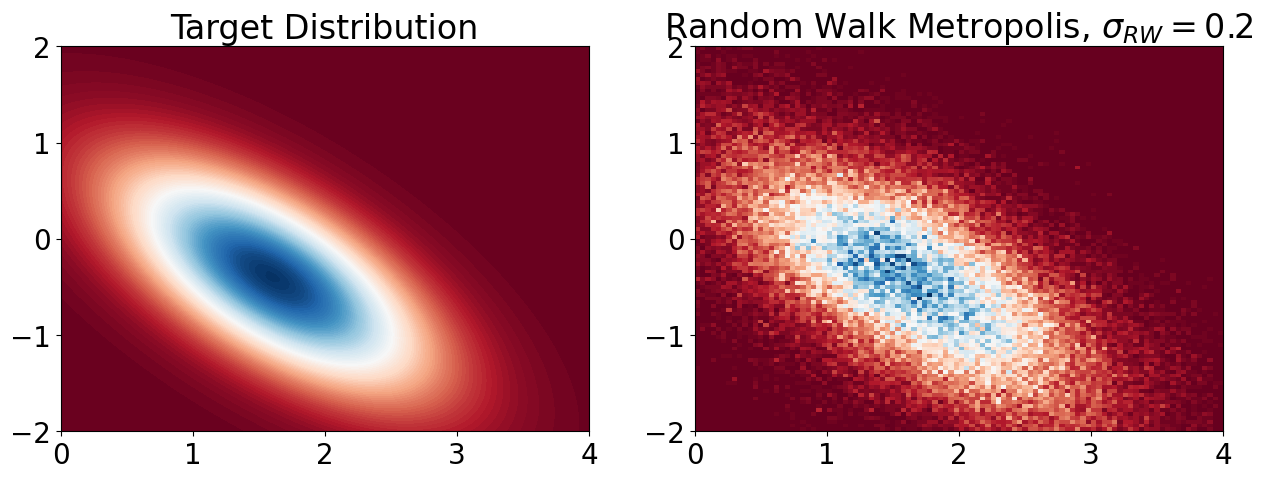

In [3]:
# Set random seed
rng = np.random.default_rng(24)

# Load posterior mean and variance
post_mean = df_post['Posterior Mean'][3]
post_var = df_post['Posterior Variance'][3]
rv = multivariate_normal(mean=post_mean, cov=post_var)

# Define log of the new target distribution
def logPi(x):
    return rv.logpdf(x)

# MCMC Sampling
def RWMH(logPi, sigma_rw = 0.5, N = 100000, burnin = 1000):
    samples_RW = np.zeros((2, N))
    samples_RW[:, 0] = np.array([0, 0])

    # Random Walk Metropolis-Hastings Algorithm
    for n in range(1, N):
        # Proposal sample from Gaussian random walk
        x_s = samples_RW[:, n-1] + sigma_rw * rng.normal(size=2)
        
        # Metropolis-Hastings acceptance step
        u = rng.uniform(0, 1)
        if np.log(u) < logPi(x_s) - logPi(samples_RW[:, n-1]):
            samples_RW[:, n] = x_s
        else:
            samples_RW[:, n] = samples_RW[:, n-1]
    return samples_RW

burnin = 1000
samples_RW = RWMH(logPi, sigma_rw = 0.2, burnin=burnin)

# Visualization
x_bb = np.linspace(0, 4, 100)
y_bb = np.linspace(-2, 2, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
pos = np.dstack((X_bb, Y_bb))
Z_bb = rv.pdf(pos)

plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 20})

# Contour plot of target distribution
plt.subplot(1, 2, 1)
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution')

# Histogram of sampled points
plt.subplot(1, 2, 2)
plt.hist2d(samples_RW[0, burnin:], samples_RW[1, burnin:], 
           100, cmap='RdBu', range=[[0, 4], [-2, 2]], density=True)
plt.title('Random Walk Metropolis, $\\sigma_{RW} = 0.2$')
plt.show()

### 1.4

In [4]:
import statsmodels.api as sm

sigma_values = np.logspace(-4, np.log10(4), num=10)

acf_results = {} # Store results
samples_results = {}

for sigma_rw in sigma_values:
    samples_RW = RWMH(logPi, sigma_rw=sigma_rw, burnin=burnin)
    
    # Store results
    acf_results[sigma_rw] = sm.tsa.acf(samples_RW[0, burnin:], nlags=50)
    samples_results[sigma_rw] = samples_RW

# Find the best sigma_rw (lowest autocorrelation at lag 1)
best_sigma_rw = min(acf_results, key=lambda s: acf_results[s][1])
samples_RW_best = samples_results[best_sigma_rw]
print(f'Best sigma_rw: {best_sigma_rw}')


Best sigma_rw: 1.2323100555166684


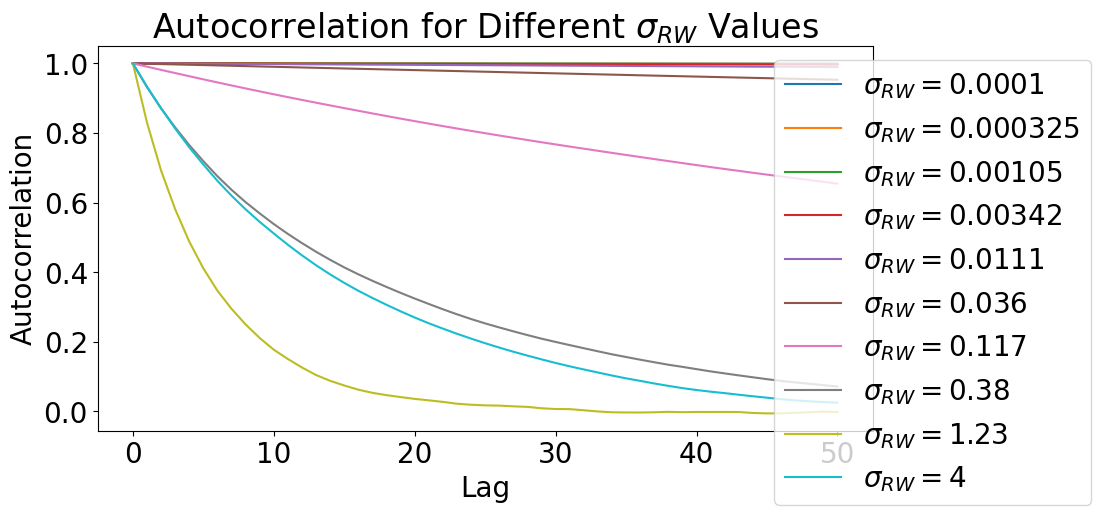

In [5]:
# plot acf for each sigma_rw
fig, ax = plt.subplots(figsize=(10, 5))
for sigma_rw in sigma_values:
    ax.plot(acf_results[sigma_rw], label=f'$\\sigma_{{RW}} = {sigma_rw:.3g}$')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation for Different $\\sigma_{RW}$ Values')
# smaller legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

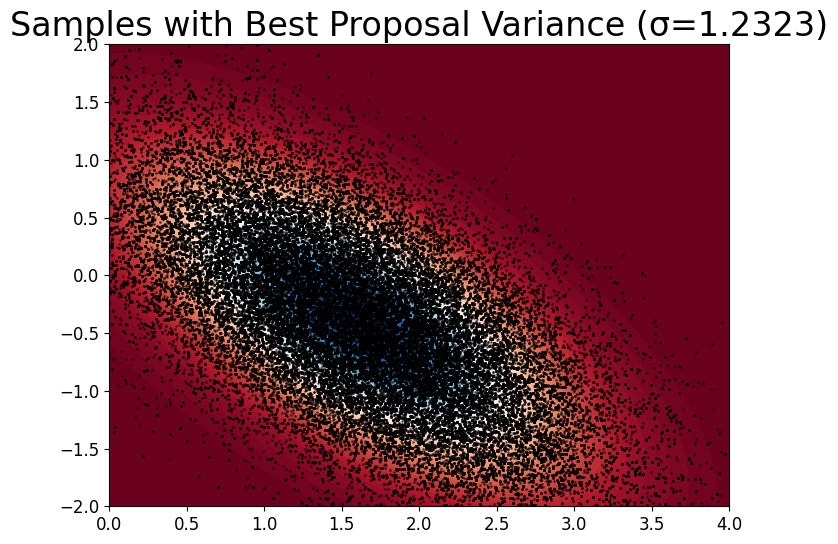

In [6]:
# Visualization
x_bb = np.linspace(0, 4, 100)
y_bb = np.linspace(-2, 2, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
pos = np.dstack((X_bb, Y_bb))
Z_bb = rv.pdf(pos)

plt.figure(figsize=(8, 6))
plt.tick_params(axis='y', labelsize=12) 
plt.tick_params(axis='x', labelsize=12)
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.scatter(samples_RW_best[0, burnin:], samples_RW_best[1, burnin:], s=1, color='black', alpha=0.5)
plt.title(f'Samples with Best Proposal Variance (σ={best_sigma_rw:.4f})')
plt.xlim(0, 4)
plt.ylim(-2, 2)
plt.show()

We report that the best variance is 1.2323

### 1.5

Best epsilon: 1.0


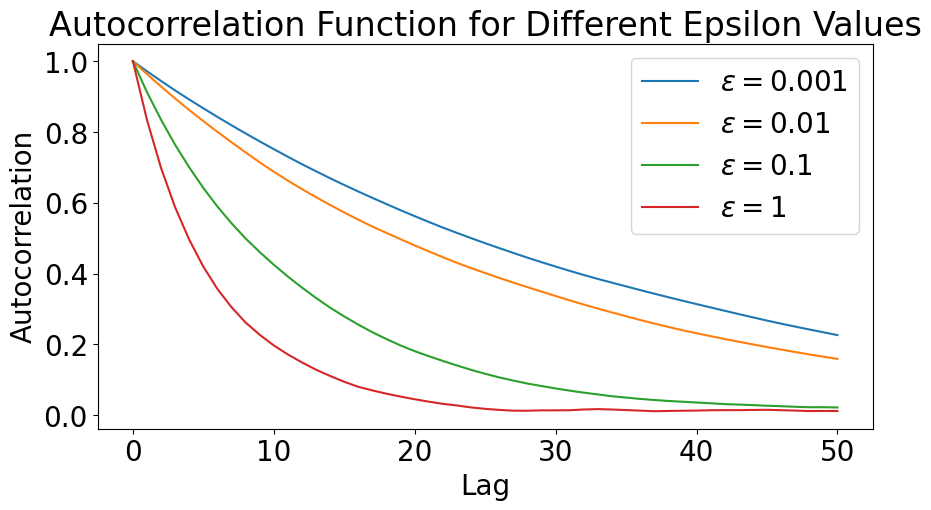

In [7]:
sigma_rw = 1.2323

fig, ax = plt.subplots(figsize=(10, 5))
acf_eps = {}

for i in df_post.index:
    eps = df_post['Epsilon'][i]
    post_mean = df_post['Posterior Mean'][i]
    post_var = df_post['Posterior Variance'][i]

    # rv = multivariate_normal(mean=mu_theta, cov=Sigma)
    rv = multivariate_normal(mean=post_mean, cov=post_var)
    
    # def logPi(x):
    #     return rv.logpdf(x)
    samples_RW = RWMH(logPi= lambda x, rv=rv: rv.logpdf(x),
                       sigma_rw=sigma_rw)

    Z_bb = rv.pdf(pos) # Evaluate the posterior density on the grid
        
    # Store results
    acf_eps[eps] = sm.tsa.acf(samples_RW[0, burnin:], nlags=50)

    ax.plot(acf_eps[eps], label=f'$\\epsilon = {eps:.3g}$')

# Find the best eps (lowest autocorrelation at lag 1)
best_eps = min(acf_eps, key=lambda e: acf_eps[e][1])
print(f'Best epsilon: {best_eps}')

ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function for Different Epsilon Values")
ax.legend()
plt.show()



We clearly observe that eps=1 leads to fastest convergence of ACF, with autocorr reaching near 0 within 30 lags.

$\epsilon=1$ is the best out of the four epsilons make sense, because it maximizes the likelihood.

Under $\epsilon=1$, the posterior mean for $\theta$ is [1.6016, -0.3984], cloest to the mean (and maximum) of (2, 0) for $\theta$ under the prior, out of the four.

We also note that expected x under the prior (without any data) is 
$$
Cm = \begin{pmatrix}1 & 1\\[4pt] 1 & 1.01\end{pmatrix}
\begin{pmatrix}2 \\[4pt] 0\end{pmatrix} = \begin{pmatrix}2 \\[4pt] 2\end{pmatrix} 
$$

And the information we have about y under prior of $x, \theta$ is

$$
A\begin{pmatrix}2 \\[4pt] 2\end{pmatrix}  = \begin{pmatrix}1 & 0 \\[4pt]\varepsilon & 0\end{pmatrix}\begin{pmatrix}2 \\[4pt] 2\end{pmatrix} = 
\begin{pmatrix}2 \\[4pt] 2 \epsilon \end{pmatrix} 
$$

$$
y \sim \mathcal{N}\left(\begin{pmatrix}2 \\[4pt] 2 \epsilon \end{pmatrix} ,
 \begin{pmatrix}\epsilon & 0\\[4pt] 0 & \epsilon \end{pmatrix} \right)
$$

Given that y is observed to be (1, 1), this suggests that we want a larger $\epsilon$ to account for the difference of data to the prior mean, and we have information that two entries of y are identical, which suggest that $2\epsilon$ should be close to 2

This leads us to choose $\epsilon=1$
